# NFL 4th-Down Win Percentage Recommendation

- Author: Marco Villagran
- Seasons: 2016-2024

In [1]:
import os, json, math
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

COL_W, TWO_COL_W = 3.5, 7.2
WIDTH = COL_W
HEIGHT = WIDTH * 1.9

mpl.rcParams.update({
    "font.size": 8, "axes.titlesize": 9, "axes.labelsize": 8,
    "xtick.labelsize": 7, "ytick.labelsize": 7, "legend.fontsize": 7,
    "axes.grid": True, "grid.linewidth": 0.4, "grid.alpha": 0.3,
    "axes.spines.top": False, "axes.spines.right": False,
    "figure.dpi": 150, "savefig.dpi": 300,
    "savefig.bbox": "tight", "savefig.pad_inches": 0.02
})
colors = {"go":"#1b9e77", "fg":"#d95f02", "punt":"#7570b3"}

DATA = "../data/processed/4thdown_labeled.csv"
RAW_PBP = "../data/raw/pbp_2016_2024.parquet"

os.makedirs("reports/figures", exist_ok=True)

df = pd.read_csv(DATA)
df_raw = pd.read_parquet(RAW_PBP)
print("Number of 4th downs", len(df))
print("Number of columns:" , len(df.columns))
print("columns: ", df.dtypes)

Number of 4th downs 37335
Number of columns: 27
columns:  season                      int64
game_id                    object
play_id                     int64
quarter                     int64
game_seconds_remaining      int64
half_seconds_remaining      int64
yardline_100                int64
ydstogo                     int64
score_differential          int64
receive_2h_ko                bool
timeouts_off                int64
timeouts_def                int64
roof                       object
surface                    object
temp_f                    float64
wind_mph                  float64
spread_line               float64
wp                        float64
wp_go                     float64
wp_fg                     float64
wp_punt                   float64
dwp_go                    float64
dwp_fg                    float64
dwp_punt                  float64
p_fg_make                 float64
p_go_convert              float64
punt_net_yds              float64
dtype: object


## 01 Data Cleaning

### Data Normalization

In [2]:
# Normalize roof (open or closed)
df['roof'].value_counts(normalize=True)
df['roof'].replace({'dome':'closed', 'outdoors':'open'}, inplace=True)

# Normalize surface (grass or turf)
df['surface'] = np.where(df['surface'] == 'grass', 'grass', 'turf')

closed_mask = df['roof'].isin(['closed'])
open_mask   = ~closed_mask

### Missing values handling

In [3]:
# Cols with missing values
missing = df.isna().mean()
missing = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing values (% missing):")
print((missing * 100).round(2))

Columns with missing values (% missing):
punt_net_yds    100.00
temp_f           34.34
wind_mph         34.34
wp_punt          26.04
dwp_punt         26.04
p_go_convert      0.00
dtype: float64


In [4]:
df = df.drop(columns=["punt_net_yds"])

# drop rows without target variables (WP diff)
targets = ["wp_go","wp_fg","wp_punt"]

before = len(df)
df = df.dropna(subset=targets)
print("Dropped rows with missing Win Percentages:", before - len(df))

# compute win_percentage differentials from win percentages
if "wp" not in df.columns:
    df["wp"] = df[["wp_go","wp_fg","wp_punt"]].max(axis=1)
    
df["dwp_go"]   = df["wp_go"]   - df["wp"]
df["dwp_fg"]   = df["wp_fg"]   - df["wp"]
df["dwp_punt"] = df["wp_punt"] - df["wp"]

Dropped rows with missing Win Percentages: 9723


In [5]:
# Fill temp_f by roof type
avg_open_temp = df.loc[open_mask, 'temp_f'].mean()
df.loc[closed_mask, 'temp_f'] = df.loc[closed_mask, 'temp_f'].fillna(70.0)
df.loc[open_mask, 'temp_f'] = df.loc[open_mask, 'temp_f'].fillna(avg_open_temp)

# Do the same for wind_mph
avg_open_wind = df.loc[open_mask, 'wind_mph'].mean()
df.loc[closed_mask, 'wind_mph'] = df.loc[closed_mask, 'wind_mph'].fillna(0.0)
df.loc[open_mask, 'wind_mph'] = df.loc[open_mask, 'wind_mph'].fillna(avg_open_wind)

### Hygiene clips

In [6]:
# yards
df["yardline_100"] = df["yardline_100"].clip(0, 100)
df["ydstogo"] = df["ydstogo"].clip(lower=1)

# game time
df["quarter"] = df["quarter"].clip(1, 6).astype("Int64")
df["game_seconds_remaining"] = df["game_seconds_remaining"].clip(lower=0)
df["half_seconds_remaining"] = df["half_seconds_remaining"].clip(lower=0)

# game score
df["score_differential"] = df["score_differential"]
df["timeouts_off"] = df["timeouts_off"].clip(0, 3).fillna(0).astype(int)
df["timeouts_def"] = df["timeouts_def"].clip(0, 3).fillna(0).astype(int)

## 02 EDA

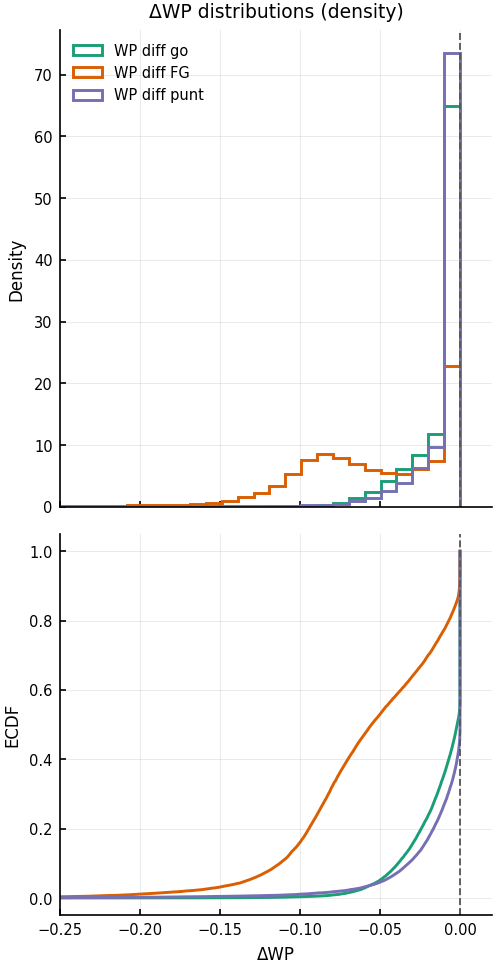

In [8]:
series = [
    np.asarray(df["dwp_go"],   float),
    np.asarray(df["dwp_fg"],   float),
    np.asarray(df["dwp_punt"], float),
]
labels = ["WP diff go", "WP diff FG", "WP diff punt"]
keys   = ["go", "fg", "punt"]  # match colors dict keys
series = [s[np.isfinite(s)] for s in series]

# shared bins
lo = min(s.min() for s in series)
hi = max(s.max() for s in series)
edges = np.linspace(lo, hi, 60 + 1)

fig, (ax_pdf, ax_ecdf) = plt.subplots(
    2, 1, figsize=(WIDTH, HEIGHT), sharex=True,
    gridspec_kw={"height_ratios": [2.0, 1.6]}
)

# density
for s, lab, key in zip(series, labels, keys):
    ax_pdf.hist(s, bins=edges, histtype="step", density=True,
                label=lab, linewidth=1.4, color=colors[key])
ax_pdf.axvline(0.0, color="0.35", linestyle="--", linewidth=0.9)
ax_pdf.set_title("ΔWP distributions (density)")
ax_pdf.set_ylabel("Density")
ax_pdf.legend(loc="upper left", frameon=False)
ax_pdf.tick_params(direction="in", which="both", length=3, width=0.8)
ax_pdf.set_xlim(-0.25, 0.02)  # zoom

# ECDF
for s, lab, key in zip(series, labels, keys):
    x = np.sort(s); F = np.arange(1, x.size + 1) / x.size
    ax_ecdf.plot(x, F, label=lab, linewidth=1.4, color=colors[key])
ax_ecdf.axvline(0.0, color="0.35", linestyle="--", linewidth=0.9)
ax_ecdf.set_xlabel("ΔWP")
ax_ecdf.set_ylabel("ECDF")
ax_ecdf.tick_params(direction="in", which="both", length=3, width=0.8)
ax_ecdf.set_xlim(-0.25, 0.02)

fig.tight_layout()
fig.savefig("../reports/figures/eda_dwp_dists_col.png")
plt.show()


In [9]:
# Best action
dwp_mat = df[["dwp_go","dwp_fg","dwp_punt"]].to_numpy()
vals = np.where(np.isnan(dwp_mat), -np.inf, dwp_mat)
best_idx = vals.argmax(axis=1)
idx_to_name = {0:"go", 1:"fg", 2:"punt"}
df["teacher_best"] = pd.Series(best_idx, index=df.index).map(idx_to_name)

# Best margin (top - second best)
top2 = np.sort(vals, axis=1)[:, -2:]
df["best_margin"] = top2[:,1] - top2[:,0]

print("Toss-up rate (WP differential gap < 0.5%):", (df["best_margin"] < 0.005).mean().round(3))
print(df["teacher_best"].value_counts(normalize=True).rename("share").round(3))

Toss-up rate (WP differential gap < 0.5%): 0.299
punt    0.515
go      0.423
fg      0.061
Name: share, dtype: float64


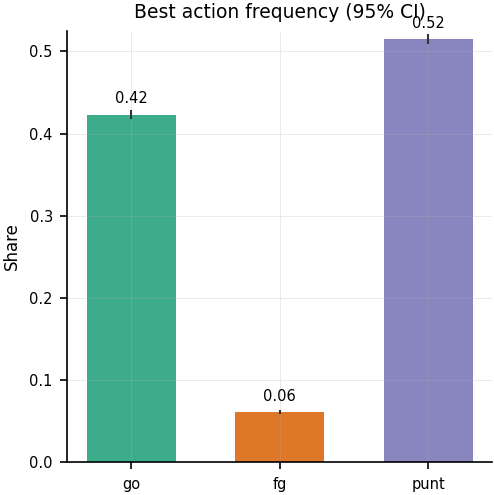

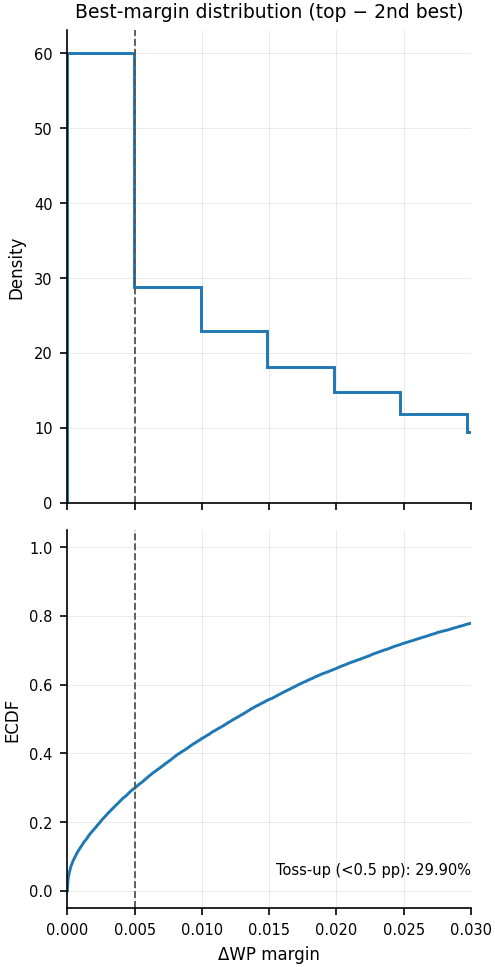

In [11]:
# --- Best action frequency with 95% CI ---
labels = ["go","fg","punt"]
n = len(df)
counts = df["teacher_best"].value_counts().reindex(labels, fill_value=0).to_numpy()
props  = counts / n

# bootstrap
B = 2000
rng = np.random.default_rng(42)
idx = rng.integers(0, n, size=(B, n))
boots = np.zeros((3, B))
y = df["teacher_best"].to_numpy()
for b in range(B):
    sample = y[idx[b]]
    for j, lab in enumerate(labels):
        boots[j, b] = (sample == lab).mean()

ci_low = np.percentile(boots, 2.5, axis=1)
ci_hi  = np.percentile(boots, 97.5, axis=1)

fig, ax = plt.subplots(figsize=(COL_W, 1.0*COL_W))
x = np.arange(len(labels))
ax.bar(x, props, width=0.6, color=[colors[l] for l in labels], alpha=0.85)
ax.vlines(x, ci_low, ci_hi, colors="0.2", linewidth=1.0)
ax.set_xticks(x, labels)
ax.set_ylim(0, max(0.01 + props.max(), 0.5))
ax.set_ylabel("Share")
ax.set_title("Best action frequency (95% CI)")
for i, p in enumerate(props):
    ax.text(i, p + 0.01, f"{p:.2f}", ha="center", va="bottom", fontsize=7)
fig.tight_layout()
fig.savefig("reports/figures/best_action_share.pdf")
fig.savefig("reports/figures/best_action_share.png")
plt.show()

# --- Best-margin distribution + ECDF (zoomed) ---
m = df["best_margin"].to_numpy()
m = m[np.isfinite(m)]
th = 0.005  # 0.5 pp threshold

fig, (ax_pdf, ax_ecdf) = plt.subplots(
    2, 1, figsize=(COL_W, COL_W*1.9), sharex=True,
    gridspec_kw={"height_ratios": [2.0, 1.6]}
)

edges = np.linspace(m.min(), m.max(), 80)
ax_pdf.hist(m, bins=edges, histtype="step", density=True, linewidth=1.4)
ax_pdf.axvline(th, color="0.35", linestyle="--", linewidth=0.9)
ax_pdf.set_ylabel("Density")
ax_pdf.set_title("Best-margin distribution (top − 2nd best)")

x_sorted = np.sort(m)
F = np.arange(1, x_sorted.size + 1) / x_sorted.size
ax_ecdf.plot(x_sorted, F, linewidth=1.4)
ax_ecdf.axvline(th, color="0.35", linestyle="--", linewidth=0.9)
ax_ecdf.set_xlabel("ΔWP margin")
ax_ecdf.set_ylabel("ECDF")

ax_pdf.set_xlim(0.0, 0.03)
ax_ecdf.set_xlim(0.0, 0.03)

rate = (m < th).mean()
ax_ecdf.text(0.03, 0.04, f"Toss-up (<0.5 pp): {rate:.2%}",
             ha="right", va="bottom", fontsize=7)

fig.tight_layout()
fig.savefig("../reports/figures/best_margin_zoom.png")
plt.show()


In [ ]:
a

NameError: name 'a' is not defined

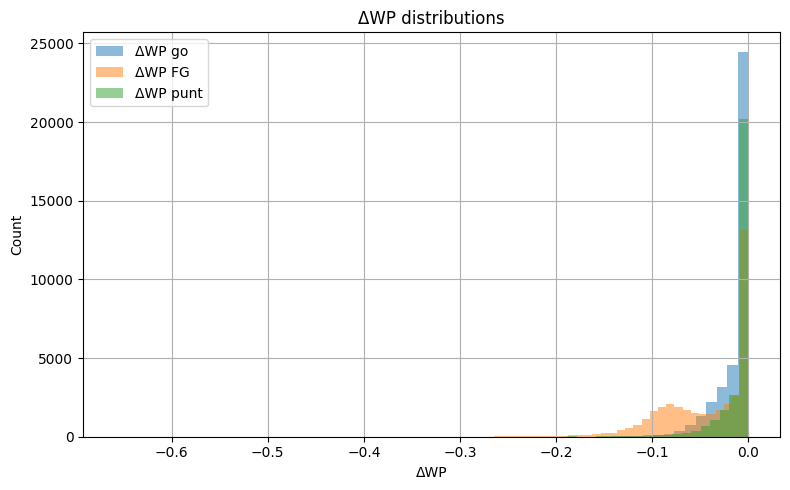

punt    0.642
go      0.313
fg      0.045
Name: share, dtype: float64

In [ ]:
# ΔWP histograms
fig, ax = plt.subplots()
ax.hist(df["dwp_go"], bins=60, alpha=.5, label="ΔWP go")
ax.hist(df["dwp_fg"], bins=60, alpha=.5, label="ΔWP FG")
ax.hist(df["dwp_punt"], bins=60, alpha=.5, label="ΔWP punt")
ax.legend(); ax.set_title("ΔWP distributions"); ax.set_xlabel("ΔWP"); ax.set_ylabel("Count")
plt.tight_layout(); plt.savefig("reports/figures/eda_dwp_hists.png"); plt.show()

# Best option overall
dwp = np.c_[df.dwp_go.values, df.dwp_fg.values, df.dwp_punt.values]
best_idx = dwp.argmax(1)
idx_to_name = {0:"go", 1:"fg", 2:"punt"}
df["teacher_best"] = pd.Series(best_idx).map(idx_to_name)
df["best_margin"] = np.sort(dwp, axis=1)[:,-1] - np.sort(dwp, axis=1)[:,-2]

df["teacher_best"].value_counts(normalize=True).rename("share").round(3)


In [ ]:
# Toss-up rate: where model should be humble (ΔWP gap < 0.5 pp)
TOSSUP = 0.005
toss = (df["best_margin"] < TOSSUP).mean()
print("Toss-up rate (ΔWP gap < 0.5 pp):", round(toss,3))

Toss-up rate (ΔWP gap < 0.5 pp): 0.221


corr(fg_dist_yd, p_fg_make): -0.9134308122047127
corr(ydstogo, p_go_convert): -0.9222781876329331


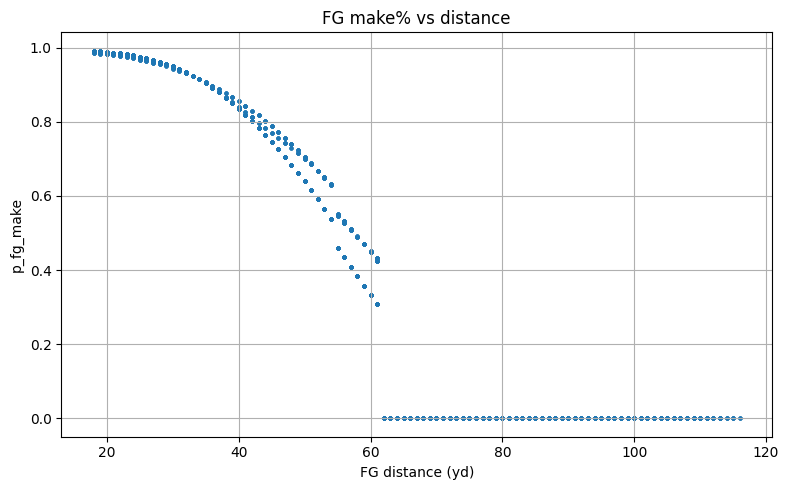

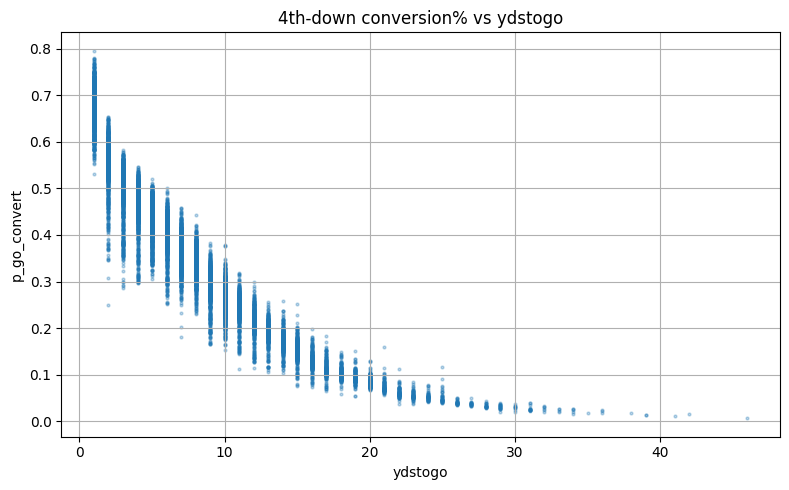

In [ ]:
# FG distance proxy (line of scrimmage + 17 yards)
df["fg_dist_yd"] = df["yardline_100"] + 17

# Correlations expected to be negative
print("corr(fg_dist_yd, p_fg_make):", df[["fg_dist_yd","p_fg_make"]].corr().iloc[0,1])
print("corr(ydstogo, p_go_convert):", df[["ydstogo","p_go_convert"]].corr().iloc[0,1])

# Simple scatter samples
s = df.sample(min(15000, len(df)), random_state=42)
fig, ax = plt.subplots()
ax.scatter(s["fg_dist_yd"], s["p_fg_make"], s=4, alpha=.3)
ax.set_title("FG make% vs distance"); ax.set_xlabel("FG distance (yd)"); ax.set_ylabel("p_fg_make")
plt.tight_layout(); plt.savefig("reports/figures/eda_fg_prob_vs_dist.png"); plt.show()

fig, ax = plt.subplots()
ax.scatter(s["ydstogo"], s["p_go_convert"], s=4, alpha=.3)
ax.set_title("4th-down conversion% vs ydstogo"); ax.set_xlabel("ydstogo"); ax.set_ylabel("p_go_convert")
plt.tight_layout(); plt.savefig("reports/figures/eda_go_prob_vs_ytg.png"); plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Use only the three ΔWP columns
dwp_df = df[['dwp_go','dwp_fg','dwp_punt']]

# If all three are NaN in a row, drop that row from best-choice analysis
mask_all_nan = dwp_df.isna().all(axis=1)
dwp_ok = dwp_df[~mask_all_nan]

# Treat NaNs as -inf so they never "win"
vals = dwp_ok.to_numpy()
vals_safe = np.where(np.isnan(vals), -np.inf, vals)

best_idx = vals_safe.argmax(axis=1)
name_map = {0:'go', 1:'fg', 2:'punt'}
df.loc[~mask_all_nan, 'teacher_best'] = pd.Series(best_idx, index=dwp_ok.index).map(name_map)

# best-margin (top minus second-best), still NaN-safe
top2 = np.sort(vals_safe, axis=1)[:, -2:]
df.loc[~mask_all_nan, 'best_margin'] = top2[:,1] - top2[:,0]

# (optional) keep others as NaN so they drop out of groupby shares


In [ ]:
def cut(x, bins, labels):
    return pd.cut(x, bins=bins, labels=labels, include_lowest=True)

df["yl_bin"]  = cut(df.yardline_100, [0,20,40,60,80,100], ["0-20","21-40","41-60","61-80","81-100"])
df["ytg_bin"] = cut(df.ydstogo, [1,2,3,6,10,50], ["1","2","3-6","7-10",">10"])

# Share best action by yardline bin
share_by_yl = (df.groupby("yl_bin")["teacher_best"]
                 .value_counts(normalize=True)
                 .rename("share")
                 .mul(100).round(1).unstack())
print(share_by_yl)


teacher_best    fg    go  punt
yl_bin                        
0-20          54.3  45.7   NaN
21-40         51.5  44.3   4.2
41-60          1.7  54.9  43.3
61-80          0.0  35.1  64.9
81-100         0.0  21.9  78.0


In [ ]:
# Share best action by ydstogo bin
share_by_ytg = (df.groupby("ytg_bin")["teacher_best"]
                  .value_counts(normalize=True)
                  .rename("share")
                  .mul(100).round(1).unstack())
print(share_by_ytg)


teacher_best    fg    go  punt
ytg_bin                       
1              7.3  89.5   3.2
2             16.1  68.9  14.9
3-6           20.8  50.7  28.4
7-10          25.6  25.9  48.5
>10           22.7   7.5  69.8


In [ ]:
# Late/close situations — where the app will shine
late_close = df[(df.game_seconds_remaining < 600) & (df["score_differential"].abs() <= 8)]
late_close["teacher_best"].value_counts(normalize=True).rename("share").round(3)
print("Toss-up rate in late/close:", (late_close["best_margin"] < 0.005).mean().round(3))


Toss-up rate in late/close: 0.096


In [ ]:
# Environment influence
for col in ["roof","surface"]:
    print("\n==", col.upper(), "==")
    print(df.groupby(col)["teacher_best"].value_counts(normalize=True).rename("share").mul(100).round(1).unstack())



== ROOF ==
teacher_best    fg    go  punt
roof                          
closed        20.0  44.0  36.1
dome          19.5  47.1  33.5
open          22.2  43.8  34.0
outdoors      19.4  41.0  39.6

== SURFACE ==
teacher_best    fg    go  punt
surface                       
a_turf        21.0  40.2  38.8
astroturf     19.4  43.3  37.3
fieldturf     19.5  43.0  37.5
grass         19.4  41.2  39.4
matrixturf    19.8  48.1  32.1
sportturf     19.6  47.2  33.1


In [ ]:
pbp = pd.read_parquet(RAW_PBP)  # raw play-by-play
coach = pbp.loc[pbp["down"].eq(4), ["game_id","play_id","play_type"]].copy()

# Map play_type -> choice
GO_TYPES = {"run","pass","qb_kneel","qb_spike","timeout","no_play"}  # runs/passes count as "go"
def map_choice(pt):
    if pd.isna(pt): return np.nan
    pt = str(pt).lower()
    if pt == "field_goal": return "fg"
    if pt == "punt": return "punt"
    if pt in GO_TYPES: return "go"
    # Unknowns (e.g., 'fake_punt', onside kicks shouldn’t appear)
    return np.nan

coach["coach_choice"] = coach["play_type"].map(map_choice)
coach = coach.dropna(subset=["coach_choice"])

eda = df.merge(coach[["game_id","play_id","coach_choice"]], on=["game_id","play_id"], how="left")
eda["disagree"] = eda["coach_choice"].ne(eda["teacher_best"])

# Regret (teacher best ΔWP - chosen ΔWP)
def chosen_dwp(row):
    if row["coach_choice"] == "go":   return row["dwp_go"]
    if row["coach_choice"] == "fg":   return row["dwp_fg"]
    if row["coach_choice"] == "punt": return row["dwp_punt"]
    return np.nan

eda["chosen_dwp"] = eda.apply(chosen_dwp, axis=1)
eda["best_dwp"]   = eda[["dwp_go","dwp_fg","dwp_punt"]].max(axis=1)
eda["regret"]     = eda["best_dwp"] - eda["chosen_dwp"]

overall_disagree = eda["disagree"].mean()
avg_regret = eda["regret"].dropna().mean()
print('overall dissagree: ', overall_disagree)
print('average regret: ', avg_regret)

overall dissagree:  0.3090397750100442
average regret:  0.004164338683897989


In [ ]:
# Where do coaches disagree more?
regret_by_yl = eda.groupby("yl_bin")["regret"].mean().round(4)
regret_by_ytg = eda.groupby("ytg_bin")["regret"].mean().round(4)
regret_by_yl, regret_by_ytg


(yl_bin
 0-20      0.0040
 21-40     0.0042
 41-60     0.0051
 61-80     0.0037
 81-100    0.0031
 Name: regret, dtype: float64,
 ytg_bin
 1       0.0083
 2       0.0067
 3-6     0.0047
 7-10    0.0023
 >10     0.0017
 Name: regret, dtype: float64)

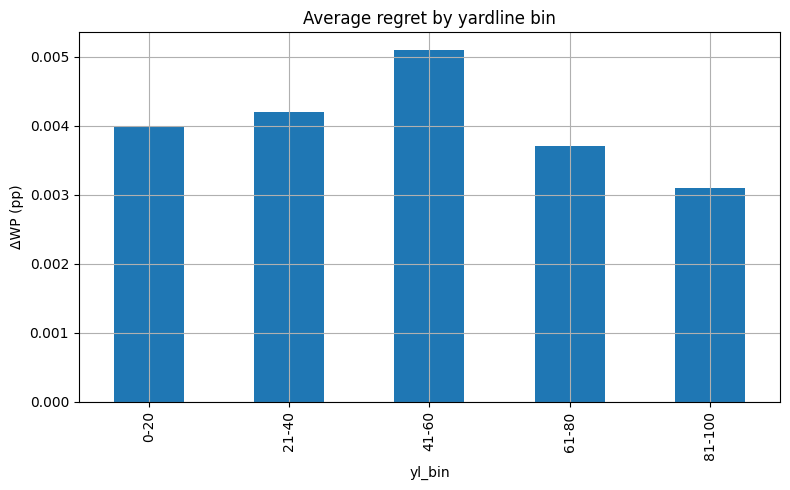

In [ ]:
# Plot regret by yardline bin
fig, ax = plt.subplots()
regret_by_yl.plot(kind="bar", ax=ax)
ax.set_title("Average regret by yardline bin")
ax.set_ylabel("ΔWP (pp)")
plt.tight_layout(); plt.savefig("reports/figures/eda_regret_by_yardline.png"); plt.show()


In [ ]:
# Ensure no clearly post-outcome columns slipped in
suspicious = [c for c in df.columns if any(k in c.lower() for k in ["td","intercept","yards_gained","epa","success"])]
suspicious

[]

In [ ]:
# Season coverage & potential drift
df.groupby("season").size()


season
2016    4056
2017    4233
2018    3929
2019    4042
2020    3832
2021    4216
2022    4286
2023    4480
2024    4261
dtype: int64

In [ ]:
summary = {
    "rows": int(len(df)),
    "seasons": [int(df["season"].min()), int(df["season"].max())],
    "teacher_best_share": df["teacher_best"].value_counts(normalize=True).round(3).to_dict(),
    "toss_up_rate": round((df["best_margin"] < 0.005).mean(), 3),
    "corr_fgprob_distance": round(df[["fg_dist_yd","p_fg_make"]].corr().iloc[0,1], 3),
    "corr_goprob_ydstogo": round(df[["ydstogo","p_go_convert"]].corr().iloc[0,1], 3),
    "coach_disagree_rate": round(overall_disagree, 3) if "overall_disagree" in locals() else None,
    "avg_regret": round(float(avg_regret), 3) if "avg_regret" in locals() and not math.isnan(avg_regret) else None
}
print(json.dumps(summary, indent=2))

{
  "rows": 37335,
  "seasons": [
    2016,
    2024
  ],
  "teacher_best_share": {
    "punt": 0.642,
    "go": 0.313,
    "fg": 0.045
  },
  "toss_up_rate": 0.221,
  "corr_fgprob_distance": -0.913,
  "corr_goprob_ydstogo": -0.922,
  "coach_disagree_rate": 0.499,
  "avg_regret": 0.004
}
